In [2]:
%matplotlib notebook

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [1]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [3]:
import os
import torch
from PIL import Image
from pathlib import Path
import albumentations as A
import numpy as np
from torchvision.transforms.functional import to_tensor, normalize
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir: Path, train: bool = True, transform = None, num_labels = 150):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        task = 'training' if train else 'validation'
        
        self.images = list((root_dir / 'images' / task).glob('*.jpg'))
        self.images.sort()
        self.annotations = list((root_dir / 'annotations' / task).glob('*.png'))
        self.annotations.sort()
        self.transform = transform
        self.num_labels = num_labels
        
    def __len__(self):
        return len(self.images)
    
    def reduce_labels(self, mask):
         # 0 (ignore) becomes 255. others are shifted by 1
        mask = mask - 1 
        return mask
        
    def get_one_hot(self, mask):
        mask = mask[mask != 255]
        labels_in_mask = np.unique(mask)
        one_hot = np.zeros(self.num_labels)
        one_hot[labels_in_mask] = 1
        return one_hot.astype(int)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]))
        mask = np.array(Image.open(self.annotations[idx]))
        
        mask = self.reduce_labels(mask)
        labels = self.get_one_hot(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
        
        image = to_tensor(image)
        labels = labels
        
        return image, mask, labels
        
        

We can defined two data augmentations, one for training and one for validating. We used [albumentations](https://albumentations.ai/docs/).

In [4]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /home/zuppif/Documents/Work/hugging_face/transformers/.venv/lib/python3.8/site-packages (1.1.0)
You should consider upgrading via the '/home/zuppif/Documents/Work/hugging_face/transformers/.venv/bin/python -m pip install --upgrade pip' command.


MaskFormer needs binary masks as targets, so we need to convert out mask from `[H,W]` to `[C, H, W]`. We can create a custom augmentation for that.

In [5]:
from albumentations import DualTransform

class ToBinaryMasks(DualTransform):
    def __init__(self, num_labels): 
        super().__init__(p=1)
        self.num_labels = num_labels
    
    def apply(self, img, **params):
        return img
    
    def apply_to_mask(self, mask, **params):
        # we need to convert mask from [W,H] to [C, W, H]
        labels = np.arange(self.num_labels)
        # broadcast is our friend
        binary_masks = mask[np.newaxis,] == labels[:, np.newaxis, np.newaxis]    
        return binary_masks.astype(np.float32)

Let's create our data pipelines

In [6]:
train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=640, height=640),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(),
    ToBinaryMasks(num_labels=150)

])

valid_transform = A.Compose([
    ToBinaryMasks(num_labels=150),
])

Let's initialize the training + validation datasets:

In [7]:
root_dir = Path('./ADE20k_toy_dataset/')

train_dataset = ImageSegmentationDataset(root_dir=root_dir, transform=train_transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, train=False, transform=valid_transform)

In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's also get the labels from our hub

In [9]:
import json
from transformers import SegformerForSemanticSegmentation
from huggingface_hub import cached_download, hf_hub_url

repo_id = "datasets/huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename)), "r"))
id2label = { int(k): v for k, v in id2label.items() }
label2id = { v: k for k, v in id2label.items() }

Let's visualize some of the masks, you can use the following interact cell to select the dataset index and one of the binary masks using their class label!

In [10]:
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension 

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [11]:
%matplotlib notebook

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


vis_dataset = ImageSegmentationDataset(root_dir=root_dir, transform=ToBinaryMasks(150))

def show_ds(idx):
    image, binary_masks, labels = vis_dataset[idx]
    image = image.permute(1,2,0)
    labels_in_masks = [v for k,v in id2label.items() if labels[k] != 0]
    
    labels_dropdown = widgets.Dropdown(options=labels_in_masks)
   
    
    def show_mask(*args):
        ax2.imshow(binary_masks[label2id[labels_dropdown.value]])
   
    fig, (ax1, ax2)  = plt.subplots(ncols=2)
    ax1.imshow(image)
    ax2.imshow(binary_masks[label2id[labels_dropdown.value]])
    
    labels_dropdown.observe(show_mask, 'value')

    return labels_dropdown
   


interact(show_ds, idx=range(len(vis_dataset)))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output()),…

<function __main__.show_ds(idx)>

Let's define our two dataloader with a custom `collate_fn`. We are using `MaskFormerFeatureExtractor.encode_inputs` the encode our inputs, under the hook they will be pad to the biggest image in the batch.

In [12]:
from transformers import MaskFormerFeatureExtractor
from torch.utils.data import DataLoader

feature_extractor = MaskFormerFeatureExtractor()

def train_collate_fn(batch):
    inputs = list(zip(*batch))
    pixel_values = inputs[0]
    annotations = [
        {"masks": masks, "labels": labels} for masks, labels in zip(inputs[1], inputs[2])
    ]
    return feature_extractor.encode_inputs(pixel_values, annotations=annotations, return_tensors='pt')

def valid_collate_fn(batch):
    inputs = list(zip(*batch))
    pixel_values = inputs[0]
    annotations = [
        {"masks": masks, "labels": labels} for masks, labels in zip(inputs[1], inputs[2])
    ]
    return  feature_extractor(list(pixel_values), annotations=annotations, return_tensors='pt')


train_dataloader = DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, collate_fn=valid_collate_fn, batch_size=2)

In [13]:
batch = next(iter(train_dataloader))

batch["pixel_values"].shape, batch["mask_labels"].shape, batch["class_labels"].shape

(torch.Size([2, 3, 640, 640]),
 torch.Size([2, 150, 640, 640]),
 torch.Size([2, 150]))

<IPython.core.display.Javascript object>


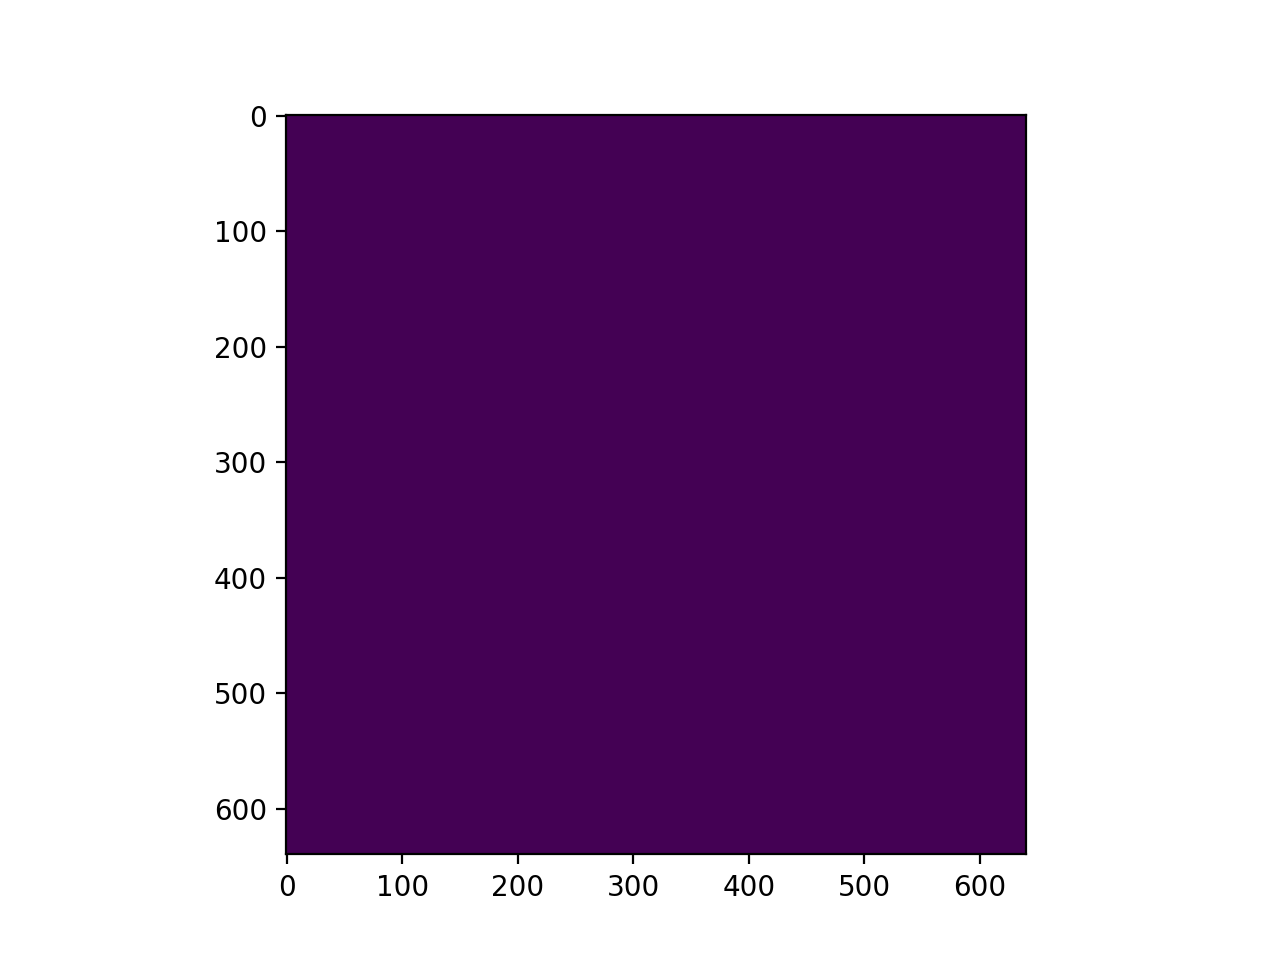

In [14]:
fig = plt.figure()
plt.imshow(batch["mask_labels"][0][0])

In [16]:
batch = next(iter(valid_dataloader))

batch["pixel_values"].shape, batch["mask_labels"].shape, batch["class_labels"].shape

(torch.Size([2, 3, 800, 1120]),
 torch.Size([2, 150, 800, 1120]),
 torch.Size([2, 150]))

## Define the model

Here we load the model

In [17]:
from transformers import MaskFormerForInstanceSegmentation

model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-small-ade")

/home/zuppif/Documents/Work/hugging_face/transformers/.venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


We can freeze the encoder to save memory

In [18]:
for param in model.model.pixel_level_module.encoder.parameters():
    param.requires_grad = False

train + validation loop

In [19]:
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


for epoch in tqdm(range(4)):  # loop over the dataset multiple times
    model.train()
    batch_bar = tqdm(train_dataloader, leave=False)
    for batch in batch_bar:
        # put the input in the right device
        batch = { k: v.to(device) for k, v in batch.items() }
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward 
        outputs = model(**batch)
        # backward 
        loss = outputs.loss
        loss.backward()
        # optimize
        optimizer.step()
        batch_bar.set_postfix({'loss': loss.item()})
        batch_bar.update()
    batch_bar.reset()
    model.eval()
    batch_bar = tqdm(valid_dataloader, leave=False)
    for batch in batch_bar:
        # forward 
        with torch.no_grad():
            outputs = model(batch["pixel_values"].to(device))
            # use the feature extractor to get the final segmentation
            mask_labels = batch["mask_labels"].cpu()
            # use the feature extractor to postprocess the outputs
            semantic_segmentation = feature_extractor.post_process_semantic_segmentation(outputs, target_size=mask_labels.shape[2:]).cpu()
            target_segmentation = mask_labels.argmax(dim=1)
            accuracy = (semantic_segmentation == target_segmentation).sum() / target_segmentation.numel()
            batch_bar.set_postfix({'accuracy': accuracy.item()})
    batch_bar.reset()



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Inference
Let's see how we can easily visualize the results from the model

In [ ]:
image, mask_labels, labels = valid_dataset[0]

with torch.no_grad():
    inputs = feature_extractor(image)
    outputs = model(**inputs)
    semantic_segmentation = feature_extractor.post_process_semantic_segmentation(outputs)

Let's see the segmentation map

In [ ]:
fig = plt.figure()
plt.imshow(semantic_segmentation[0])